In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pylab as plt
%pylab inline
import numpy as np
import geopandas as gpd

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# Create empty dataframe to store values
sales_detail = pd.DataFrame()

# urls to the data
list_sales_detail = ['http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2014/2014_manhattan.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2014/2014_bronx.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2014/2014_brooklyn.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2014/2014_queens.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2014/2014_statenisland.xls']
older_list =       ['http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2013/2013_manhattan.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2013/2013_bronx.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2013/2013_brooklyn.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2013/2013_queens.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2013/2013_statenisland.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2012/2012_manhattan.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2012/2012_bronx.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2012/2012_brooklyn.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2012/2012_queens.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2012/2012_statenisland.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2011/2011_manhattan.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2011/2011_bronx.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2011/2011_brooklyn.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2011/2011_queens.xls',
                    'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2011/2011_statenisland.xls']
even_older_list = ['http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2010/2010_manhattan.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2010/2010_bronx.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2010/2010_brooklyn.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2010/2010_queens.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2010/2010_statenisland.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2009_manhattan.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2009_bronx.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2009_brooklyn.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2009_queens.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2009_statenisland.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/09pdf/rolling_sales/sales_2008_manhattan.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/09pdf/rolling_sales/sales_2008_bronx.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/09pdf/rolling_sales/sales_2008_brooklyn.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/09pdf/rolling_sales/sales_2008_queens.xls',
             'http://www1.nyc.gov/assets/finance/downloads/pdf/09pdf/rolling_sales/sales_2008_statenisland.xls']

In [3]:
for url in list_sales_detail:
    xl_data = pd.read_excel(url, header=4)
    for c in xl_data.columns:
        c.rstrip('\n')
        xl_data.rename(columns={c: c.rstrip('\n')}, inplace=True)
    sales_detail = sales_detail.append(xl_data)
sales_detail.columns = map(lambda x: x.replace(' ','_'), list(sales_detail.columns))

In [4]:
# sales_detail.info()

In [5]:
sales_data_subset = sales_detail[(sales_detail.TAX_CLASS_AT_TIME_OF_SALE<3)&(sales_detail.SALE_PRICE>100000)&
                                 (sales_detail.BUILDING_CLASS_CATEGORY != '05  TAX CLASS 1 VACANT LAND')]
sales_data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53494 entries, 2 to 7435
Data columns (total 21 columns):
BOROUGH                           53494 non-null int64
NEIGHBORHOOD                      53494 non-null object
BUILDING_CLASS_CATEGORY           53494 non-null object
TAX_CLASS_AT_PRESENT              53494 non-null object
BLOCK                             53494 non-null int64
LOT                               53494 non-null int64
EASE-MENT                         53494 non-null object
BUILDING_CLASS_AT_PRESENT         53494 non-null object
ADDRESS                           53494 non-null object
APARTMENT_NUMBER                  53494 non-null object
ZIP_CODE                          53494 non-null int64
RESIDENTIAL_UNITS                 53494 non-null int64
COMMERCIAL_UNITS                  53494 non-null int64
TOTAL_UNITS                       53494 non-null int64
LAND_SQUARE_FEET                  53494 non-null int64
GROSS_SQUARE_FEET                 53494 non-null int64
YEAR_

In [6]:
# Approximate the value of each unit within the sold building
# If there are no residential units in the building, the sale_price_unit is just the sale_price
sales_data_subset['SALE_PRICE_UNIT'] = np.where(sales_data_subset['RESIDENTIAL_UNITS']==0,sales_data_subset.SALE_PRICE, (sales_data_subset.SALE_PRICE/sales_data_subset.RESIDENTIAL_UNITS))

In [7]:
# Round and convert to integer
sales_data_subset['SALE_PRICE_UNIT'] = np.around(sales_data_subset['SALE_PRICE_UNIT'],decimals=0)
sales_data_subset['SALE_PRICE_UNIT'] = sales_data_subset['SALE_PRICE_UNIT'].astype(int)

In [8]:
# Create BBL
sales_data_subset[['BOROUGH','BLOCK','LOT']] = sales_data_subset[['BOROUGH','BLOCK','LOT']].astype(str)
sales_data_subset['BBL'] = sales_data_subset.BOROUGH + sales_data_subset.BLOCK + sales_data_subset.LOT

In [9]:
sales_data_subset.SALE_PRICE_UNIT.describe()

count    5.349400e+04
mean     7.926047e+05
std      2.132959e+06
min      2.580000e+02
25%      2.400000e+05
50%      4.058780e+05
75%      7.300000e+05
max      1.732986e+08
Name: SALE_PRICE_UNIT, dtype: float64

In [10]:
bins = [0,200000,400000,600000,800000,1000000,1500000,3000000,6000000,10000000,max(sales_data_subset.SALE_PRICE_UNIT)]
x_ticks = ['$(0-200k]','$(200k-400k]','$(400k-600k]','$(600k-800k]','$(800k-1m]','$(1m-1.5m]','$(1.5m-3m]',
          '$(3m-6m]','$(6m-10m]','$(10m-~170.5m]']
labels = np.arange(1,11,1)

In [11]:
sales_data_subset['PRICE_BINS'] = pd.cut(sales_data_subset.SALE_PRICE,bins,labels=labels)

In [12]:
count = {}
for i in sales_data_subset['PRICE_BINS']:
    count[i] = count.get(i, 0) + 1   

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

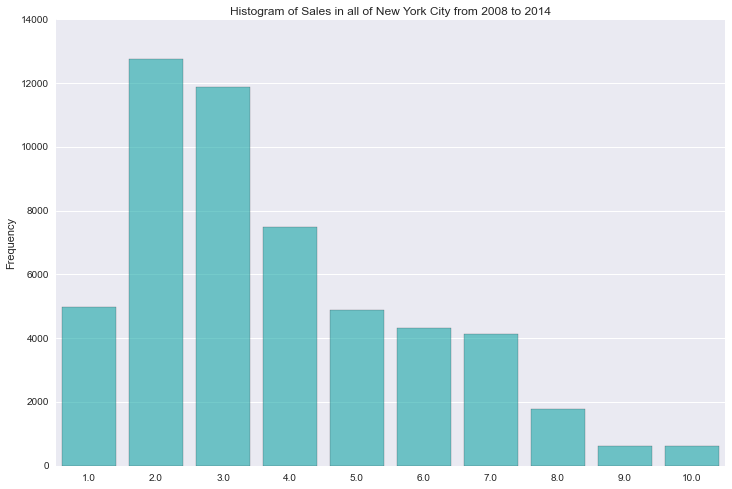

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
df = pd.DataFrame.from_dict(count, 'index')
sns.barplot(x=df.index,y=df[0],color='c',alpha=0.6)
plt.title('Histogram of Sales in all of New York City from 2008 to 2014')
plt.ylabel('Frequency')
ax.xaxis.get_majorticklocs()
#ax.xaxis.set_ticks(x_ticks)
#plt.xticks([i for i in labels],[str(w) for w in x_ticks]) 

In [14]:
print sales_data_subset['SALE_PRICE'].groupby(sales_data_subset['TAX_CLASS_AT_TIME_OF_SALE']).mean()
print sales_data_subset['SALE_PRICE'].groupby(sales_data_subset['TAX_CLASS_AT_TIME_OF_SALE']).std()

TAX_CLASS_AT_TIME_OF_SALE
1     664968
2    1703576
Name: SALE_PRICE, dtype: int64
TAX_CLASS_AT_TIME_OF_SALE
1     1058144.814984
2    21206854.854726
Name: SALE_PRICE, dtype: float64


In [15]:
import requests, zipfile, StringIO
url_zip = 'https://www.dropbox.com/sh/nlbj8whi5izbihr/AAD8CvKIYMnVpKUcBDazRe22a?dl=1'
r = requests.get(url_zip)
zip_ = zipfile.ZipFile(StringIO.StringIO(r.content))

In [16]:
filename = 'ZIP_spatial/ZIP_CODE_040114.shp'
zipcodes = gpd.GeoDataFrame.from_file(filename)#zip_.open(filename)) # Does not work...
zipcodes = zipcodes[['ZIPCODE','geometry']]
zipcodes.ZIPCODE = zipcodes.ZIPCODE.astype(int)
zipcodes.rename(columns={'ZIPCODE':'ZIP_CODE'},inplace=True)
final = sales_data_subset.merge(zipcodes,on='ZIP_CODE',how='inner')
final = gpd.GeoDataFrame(final)

In [65]:
tax_breakdown = pd.DataFrame({'COUNT':final.groupby(['TAX_CLASS_AT_TIME_OF_SALE','PRICE_BINS'],axis=0).size()}).reset_index()
total_breakdown = pd.DataFrame({'COUNT':final.groupby(['TAX_CLASS_AT_TIME_OF_SALE','PRICE_BINS','ZIP_CODE'],axis=0).size()}).reset_index()

In [63]:
total1 = tax_breakdown[tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==1]['COUNT'].sum()
total2 = tax_breakdown[tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==2]['COUNT'].sum()
tax_breakdown['SHARE'] = np.where(tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==2,tax_breakdown['COUNT']/total2, tax_breakdown['COUNT']/total1)
del total1
del total2

In [70]:
zip_tax_breakdown = pd.DataFrame({'COUNT':final.groupby(['ZIP_CODE','TAX_CLASS_AT_TIME_OF_SALE'],axis=0).size()}).reset_index()

In [72]:
# Normalize each count by total sales count and maybe by population
zip_tax_breakdown[:10]

,ZIP_CODE,TAX_CLASS_AT_TIME_OF_SALE,COUNT
0,10001,1,2
1,10001,2,173
2,10002,1,1
3,10002,2,295
4,10003,1,5
5,10003,2,800
6,10004,2,428
7,10005,2,154
8,10006,2,111
9,10007,2,104
